# Explore pyiron-like workflows

Aim: Explore how close the presently available features of the pyiron_workflow class allow us to write pyiron-like workflows

In [1]:
%config IPCompleter.evaluation='unsafe'

import matplotlib.pylab as plt
from pyiron_workflow.workflow import Workflow

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Create structure and list available potentials

In [3]:
wf = Workflow('Lammps')
wf.register('atomistics', 'pyiron_workflow.node_library.atomistics')
wf.register('lammps', 'pyiron_workflow.node_library.lammps')
wf.register('atomistic_codes', 'pyiron_workflow.node_library.atomistic_codes')

In [4]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)
list_potentials = wf.create.lammps.ListPotentials(structure=repeat)    
#wf.run()
#list_potentials.outputs.potentials.value[:5]

In [5]:
wf = Workflow('Lammps')
structure = wf.create.atomistics.Bulk('Al', cubic=True)
repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=1)

lammps = wf.create.atomistic_codes.Lammps(structure=repeat, label='lammps')
lammps.list_pots()[:5]
#lammps.list_pots.pull()
#wf.run()

['1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1']

In [6]:
out = wf.run()
print (f'Potential energy: {wf.lammps.outputs.generic.value.energy_pot.values[0]}')

Potential energy: -13.4399999882896


### MD over list of temperatures

CPU times: user 370 ms, sys: 143 ms, total: 513 ms
Wall time: 2.4 s


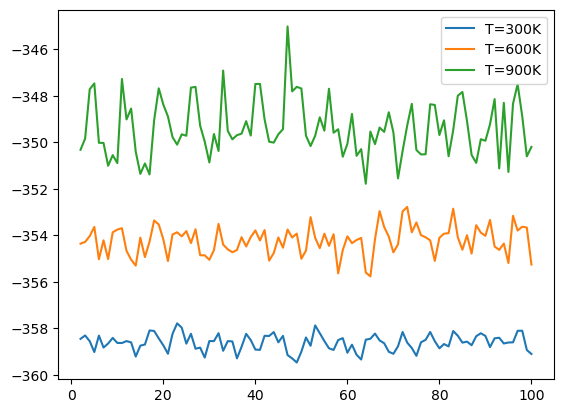

In [7]:
%%time
for T in [300, 600, 900]:
    wf = Workflow('Lammps')
    structure = wf.create.atomistics.Bulk('Al', cubic=True)
    repeat = wf.create.lammps.Repeat(structure = structure, repeat_scalar=3)
    
    lammps = wf.create.atomistic_codes.Lammps(structure=repeat, label='lammps')
    lammps.calc_select.md(temperature=T, n_ionic_steps=10_000)
    
    wf.run()
    
    plt.plot(wf.lammps.outputs.generic.value.energy_pot[2:], label=f'T={T}K')
plt.legend();    

In [8]:
wf.draw(depth=2);

In [9]:
wf.lammps.draw();

### Murnaghan (E-V) macro

In [10]:
# volumes = wf.create.standard.Linspace(0.9, 1.1, 11)

In [11]:
@Workflow.wrap_as.macro_node()
def energy_at_volume(wf) -> None:
    bulk = wf.create.atomistics.Bulk('Al', cubic=True)
    repeat = wf.create.lammps.Repeat(structure = bulk, repeat_scalar=1)
    apply_strain = wf.create.lammps.ApplyStrain(structure=repeat, strain=1)
    
    
    lammps = wf.create.atomistic_codes.Lammps(structure=apply_strain, label='lammps')
    
    wf.inputs_map = {
        "bulk__name": "element",
        "apply_strain__strain": "strain",
        "lammps__potential__name": "potential",
    }
    wf.outputs_map = {"lammps__collect__generic": "generic"}

In [12]:
#wf.create.iter(energy_at_volume, strain=wf.create.numpy.linspace(-0.2, 0.2, 11))

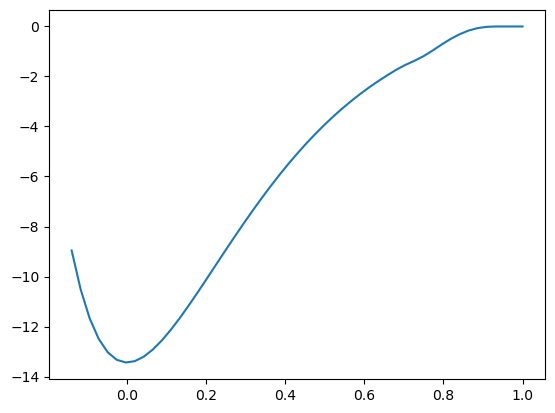

In [13]:
import numpy as np

energy_pot = []
strain_lst = np.linspace(0.86, 2, 51) - 1
for strain in strain_lst:
    wf = energy_at_volume(element='Al', strain=strain)
    out = wf.run()

    energy_pot.append(out['lammps__generic'].energy_pot.iloc[0])  

plt.plot(strain_lst, energy_pot);

#### Test pickle

In [14]:
import  cloudpickle as pickle

In [15]:
with open('node.pickle', 'wb') as f:
    pickle.dump(wf, f)

In [16]:
with open('node.pickle', 'rb') as f:
    new_node = pickle.load(f)

In [17]:
new_node.run();

In [18]:
new_node.outputs.lammps__generic.value.energy_pot

0    0
Name: PotEng, dtype: int64